In [66]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal as mvn

### Plot Gaussian

In [301]:
from matplotlib.patches import Ellipse    
        
def plot_gaussian(mus, sigmas, weights = None):
    K = len(mus)
    if weights is None:
        weights = np.ones(K)/K
    fig, ax = plt.subplots()
    
    for k in range(len(mus)):
        sigma = sigmas[k]
        val,vec = np.linalg.eig(sigma)
        angle = np.arctan2(vec[0,1], vec[0,0])
        ells = Ellipse(xy=mus[k],
                width=3.*np.sqrt(val[0]), height=3.*np.sqrt(val[1]),
                angle=np.rad2deg(angle))
        ells.set_clip_box(a.bbox)
        ells.set_alpha(weights[k])
        ax.add_artist(ells)
    plt.xlim(-10, 10)
    plt.ylim(-10, 10)
    return

### Generate Data

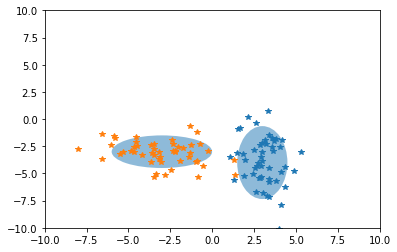

In [313]:
D = 2
mu1 = np.array([3., -4.])
sigma1 = np.diag([1., 5.])

mu2 = np.array([-3., -3.])
sigma2 = np.diag([4., 1.])

N = 100

sample1 = np.random.multivariate_normal(mu1, cov = sigma1, size = N/2)
sample2 = np.random.multivariate_normal(mu2, cov = sigma2, size = N/2)
samples = np.vstack([sample1, sample2])
plot_gaussian([mu1,mu2],[sigma1,sigma2])
plt.plot(sample1[:,0],sample1[:,1],'*')
plt.plot(sample2[:,0],sample2[:,1],'*')


In [314]:
samples.shape

(100, 2)

### Gaussian Mixture Model

In [315]:
import time

In [319]:
K = 3
pis = np.ones(K)/K
mus = np.random.rand(K,D)
sigmas = np.array([np.eye(D) for i in range(K)])
zs = np.zeros((N,K))

[[-3.4927687  -2.99636213]
 [-2.14655485 -3.20848155]
 [ 3.04003302 -3.89524721]]


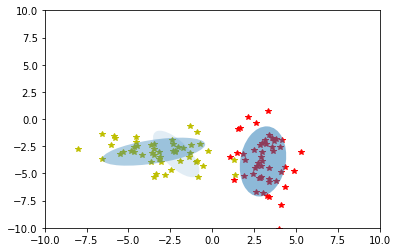

In [320]:
from IPython.display import clear_output
for j in range(20):    
    ###  E-Step
    for i in range(N):
        for k in range(K):
            zs[i,k] = pis[k]*mvn.pdf(samples[i,:],mus[k], sigmas[k])

        zs[i,:] = zs[i,:]/np.sum(zs[i,:])
    Ns = np.sum(zs,axis=0)

    ### M-Step
    for k in range(K):
        mus[k,:] = np.dot(zs[:,k].T, samples)/Ns[k]
        sigma_k = np.zeros((D,D))
        for i in range(N):
            sigma_k += zs[i,k]*np.outer(samples[i,:]-mus[k,:], samples[i,:].T-mus[k,:].T)
        sigma_k /= Ns[k]
        sigmas[k,:] = sigma_k
        pis[k] = Ns[k]/N 
    print mus
    
    plot_gaussian(mus,sigmas,pis)
    plt.plot(sample1[:,0],sample1[:,1],'r*',zorder = 0)
    plt.plot(sample2[:,0],sample2[:,1],'y*',zorder = 0)
    plt.show()
    #raw_input()
    clear_output(wait=True)
    
    time.sleep(0.1)


### Bayesian Gaussian Mixture 

In [287]:
from sklearn.mixture import BayesianGaussianMixture

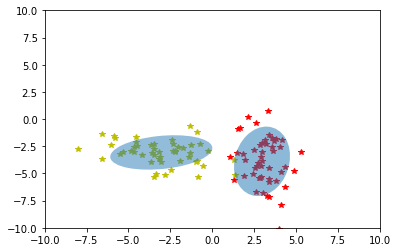

In [322]:
bgmm = BayesianGaussianMixture(n_components=4, n_init=5)
bgmm.fit(samples)
plot_gaussian(bgmm.means_, bgmm.covariances_, bgmm.weights_)
plt.plot(sample1[:,0],sample1[:,1],'r*',zorder = 0)
plt.plot(sample2[:,0],sample2[:,1],'y*',zorder = 0)

### Implement different techniques: MCMC sampling, Laplace Approximations, and Gaussian Variational Approximations 

#### MCMC sampling 